In [1]:
# ------------------------------------------------------------------------------------------------------------------------------------------------
# Les modules nécessaires externes
# ------------------------------------------------------------------------------------------------------------------------------------------------

import os
import requests
import sys
import gzip

import datetime
import time





import pandas as pd
import numpy as np



# matplotlib
import matplotlib.pyplot as plt

from ipywidgets import interact, IntSlider, FloatSlider, Dropdown, Button, HBox, VBox
import ipywidgets as widgets
import seaborn as sns
import pylab

# Scipy
import scipy.stats as stats
from scipy.stats import shapiro
from scipy.stats import ks_2samp


# Stat
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller


# ARIMA
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace import sarimax

# Métriques 
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


# Décomposition série temporelle

from statsmodels.tsa.seasonal import seasonal_decompose 



 # Tensorflow
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM


# split data
from sklearn.model_selection import train_test_split

#Pipeline
 
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer


# Normalisation
from sklearn import preprocessing


#Gestion de la mémoire
import gc



# Métriques 
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [2]:
# ------------------------------------------------------------------------------------------------------------------------------------------------
# Les modules nécessaires developpés
# ------------------------------------------------------------------------------------------------------------------------------------------------

import decomposition_serie_temporelle
import analyse_spectrale 
import pipeline_analyse_spectrale_decomposition 
import analyse_et_sarima
import sarimax_model
import lstm_model
import sequence_transformer
import inversion_transformer
import normalisation_transformation
import wrapper_pour_lstm
import realigner
# pour la mise à jour
import importlib
importlib.reload(decomposition_serie_temporelle)
importlib.reload(analyse_spectrale)
importlib.reload(pipeline_analyse_spectrale_decomposition)
importlib.reload(lstm_model)
importlib.reload(sarimax_model)
importlib.reload(analyse_et_sarima)
importlib.reload(sequence_transformer)
importlib.reload(inversion_transformer)
importlib.reload(normalisation_transformation)
importlib.reload(wrapper_pour_lstm)
importlib.reload(realigner)

from decomposition_serie_temporelle import DecompositionSerieTemporelle
from analyse_spectrale import SpectrogramAnalysis
from sarimax_model import SARIMAModel
from lstm_model import LSTMModel
from pipeline_analyse_spectrale_decomposition import SpectroDecompPipeline
from analyse_et_sarima import SpectrogramToSARIMAPipeline
from sequence_transformer import SequenceTransformer
from inversion_transformer import InversionTransformer
from normalisation_transformation import NormalisationTransformer
from wrapper_pour_lstm import WrapperforLSTM
from realigner import ReAligner 
 


In [3]:
from tensorflow.keras import backend as K
K.clear_session()
gc.collect()

0

In [4]:
# lecture des csv contenant les bases de données conso+meteo-rayonnement
folder_projet_BD = r"D:\MesDocuments\Formation\DataScientist_PSL\Projet\BD"
folder_BD_propre= os.path.join(folder_projet_BD, 'conso-inf36-meteo-rayonnement-region-propre')
liste_file = os.listdir(folder_BD_propre)

reg = 1
file = os.path.join(folder_BD_propre, liste_file[reg])
df = pd.read_csv(file, low_memory=False)


In [5]:
# Selection d'un profile et puissance
df_1 = df.loc[(df['Profil']=='RES1 (+ RES1WE)') & (df['Plage de puissance souscrite']=='P2: ]3-6] kVA')].iloc[0:372*48,:]


In [6]:
df_1.columns

Index(['Région', 'Code région', 'Profil', 'Plage de puissance souscrite',
       'Nb points soutirage', 'Total énergie soutirée (Wh)',
       'Courbe Moyenne n°1 (Wh)', 'Indice représentativité Courbe n°1 (%)',
       'Courbe Moyenne n°2 (Wh)', 'Indice représentativité Courbe n°2 (%)',
       'Courbe Moyenne n°1 + n°2 (Wh)',
       'Indice représentativité Courbe n°1 + n°2 (%)',
       'Jour max du mois (0/1)', 'Semaine max du mois (0/1)', 'AAAAMMJJHH',
       'T_moyenne', 'T_STD', 'T_min', 'T_q25', 'T_q50', 'T_q75', 'T_max',
       'T_skew', 'T_kurtosis', 'FF_moyenne', 'FF_STD', 'FF_min', 'FF_q25',
       'FF_q50', 'FF_q75', 'FF_max', 'U_moyenne', 'U_STD', 'U_min', 'U_q25',
       'U_q50', 'U_q75', 'U_max', 'date', 'year', 'month', 'month_n', 'day',
       'day_n', 'h', 'mn', 's', 'Rayonnement solaire global (W/m2)'],
      dtype='object')

In [7]:
# division par l enombre de point de soutirage
df_1['Total énergie soutirée (Wh)'] = df_1['Total énergie soutirée (Wh)']/df_1['Nb points soutirage'] #np.log(df_1['Total énergie soutirée (Wh)'])


In [8]:
# gestion des nan
def imputer_series(s, method='ffill', window=3):
    """
    Impute les valeurs manquantes d'une série temporelle.

    Parameters
    ----------
    s : pd.Series
        Série temporelle avec un DatetimeIndex.
    method : str
        Méthode d'imputation : 'interpolate', 'ffill', 'bfill', 'rolling'.
    window : int
        Taille de la fenêtre pour la moyenne glissante (si method='rolling').

    Returns
    -------
    s_filled : pd.Series
        Série avec trous imputés.
    """
    s = s.sort_index()

    if method == 'ffill':
        return s.ffill()
    elif method == 'bfill':
        return s.bfill()
    elif method == 'rolling':
        return s.rolling(window=window, center=True).mean().fillna(method='bfill').fillna(method='ffill')
    else:
        raise ValueError("Méthode d'imputation non reconnue : utilisez 'interpolate', 'ffill', 'bfill' ou 'rolling'.")
# Pour régler certaines irrégularité dans les données vues en tant que séries temporelles
def force_datetime_index(df, freq='30min'):
    """
    Force un DataFrame à avoir un DatetimeIndex régulier.

    Parameters
    ----------
    df : pd.DataFrame ou pd.Series
        Données d'entrée sans index temporel.
    freq : str
        Fréquence du pas temporel (ex : '30min', '1H').
    start_time : str or pd.Timestamp
        Date de départ pour créer l'index.

    Returns
    -------
    df_copy : pd.DataFrame or pd.Series
        Données avec un DatetimeIndex régulier.
    """

    date = pd.to_datetime(df['date'] + ' ' + df['h'].astype(str) + ':' + df['mn'].astype(str))
    start_time = df['date'].min()

    df_copy = df.copy()
    new_index = pd.date_range(start=start_time, periods=len(df_copy), freq=freq)
    df_copy.index = new_index
    return df_copy
df_1 = force_datetime_index(df_1)
df_1 = imputer_series(df_1, method='ffill', window=3)

D:\Temp\ipykernel_9944\3694033751.py:50: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  date = pd.to_datetime(df['date'] + ' ' + df['h'].astype(str) + ':' + df['mn'].astype(str))


In [9]:
spectro_params_default ={"fs": 1/1800, # Fréquence d'échantillonnage (1 point chaque 1800 secondes
                         "window": "hann",         # Fenêtre de Hann
                         "nperseg": 7*48,         # Longueur de la fenêtre d'analyse spectrale
                         "noverlap": 24,           # Recouvrement entre fenêtres
                         "threshold": 0.25      # Seuil de detection
                        } 
#test
#spectrodecomp = SpectroDecompPipeline(target_column='Total énergie soutirée (Wh)', spectro_kwargs=spectro_params_default)
#spectrodecomp.fit(df_1)
#df_t = spectrodecomp.transform(df_1)


def premiere_analyse(df,spectro_params = None, column_target = None):
        column_target = column_target or 'y'
        spectro_params = spectro_params or spectro_params_default
        spectrogram_analyzer = SpectrogramAnalysis(**spectro_params) 
        y = df[column_target]
        spectrogram_analyzer.fit(y)
        spectrogram_analyzer.transform(y) 
        #periodes = spectrogram_analyzer.transform(y) 
        return spectrogram_analyzer.dominant_periodes.astype(int).tolist()[0:2]
        #return periodes.values.flatten()
periodes =  premiere_analyse(df_1,spectro_params_default,column_target = 'Total énergie soutirée (Wh)')

print('periodes' , periodes)

periodes [22, 42]


In [10]:
# pipeline 1
L =['Total énergie soutirée (Wh)', 'T_moyenne', 'U_moyenne', 'Rayonnement solaire global (W/m2)']
analyse_decomposition_columns = {}

#["multiplicative","multiplicative","multiplicative", "multiplicative"]
target_column = 'Total énergie soutirée (Wh)'
for column, methode in zip(L, ["multiplicative","multiplicative","multiplicative", "multiplicative"]):
    if column == target_column:
        analyse_decomposition_columns[f"analyse_decomposition_{column}"] = SpectroDecompPipeline(target_column = column,
                                                                                             forme = methode, #'multiplicative' ou 'additive
                                                                                             spectro_kwargs= spectro_params_default)
    else : 
         analyse_decomposition_columns[f"analyse_decomposition_{column}"] = DecompositionSerieTemporelle(target_column=column,
                                                                                                         forme=methode,
                                                                                                         periodes=periodes
        )

pipeline = Pipeline(steps=list(analyse_decomposition_columns.items()))
display(pipeline)

Pipeline(steps=[('analyse_decomposition_Total énergie soutirée (Wh)',
                 SpectroDecompPipeline(spectro_kwargs={'fs': 0.0005555555555555556,
                                                       'noverlap': 24,
                                                       'nperseg': 336,
                                                       'threshold': 0.25,
                                                       'window': 'hann'},
                                       target_column='Total énergie soutirée '
                                                     '(Wh)')),
                ('analyse_decomposition_T_moyenne',
                 DecompositionSerieTemporelle(periodes=[22, 42],
                                              target_column='T_moyenne')),
                ('analyse_decomposition_U_moyenne',
                 DecompositionSerieTemporelle(periodes=[22, 42],
                                              target_column='U_moyenne')),
                ('analyse_decomposition_Rayonnement solaire global (W/m2)',
                 DecompositionSerieTemporelle(periodes=[22, 42],
                                              target_column='Rayonnement '
                                                            'solaire global '
                                                            '(W/m2)'))])

In [ ]:
# LSTM pour les composantes residuelle et tendancielle

windows_size = 24
lstm_params_tendance =  { 'window_size' : windows_size, 
                         'n_neurons': 128,  
                         'factor' : 0.1,
                         'epochs' : 100, 
                         'batch_size' : 32, 
                         'patience' : 3, 
                         'loss' : "mean_absolute_error",
                         'nbfoldcv' : 3, 
                         'optimize_architecture':True, # Pour chercher l'architecture optimale
                         'optimize_lr':True,  # Pour chehercher le taux optimal
                         'use_grid_search': False, # Utilsation du grid_search pour les hyperparamètres
                          #'save_path' : 'best_lstm_model_tendance.keras'
                        }

lstm_params_residuel =  { 'window_size' : windows_size, 
                         'n_neurons': 128,  
                         'factor' : 0.1,
                         'epochs' : 100, 
                         'batch_size' : 32, 
                         'patience' : 3, 
                         'loss' : "mean_absolute_error",
                         'nbfoldcv' : 3, 
                         'optimize_architecture':True, # Pour chercher l'architecture optimale
                         'optimize_lr':True,  # Pour chehercher le taux optimal
                         'use_grid_search':False, # Utilsation du grid_search pour les hyperparamètres
                         #'save_path' : 'best_lstm_model_residuel.keras'
                        }
def constructeur_pipeline_composantes(lstm_params=None, columns_to_inverse = None, column_target = None):
    
    lstm_params = lstm_params 
    columns_to_inverse = columns_to_inverse 
    column_target = column_target 



    inversion = InversionTransformer(columns_to_inverse)
    scaler = NormalisationTransformer(column_target=column_target) # Normalisation
    
    create_sequences = SequenceTransformer(window_size=lstm_params['window_size'],column_target=column_target) # Séquencement pour LSTM

    lstm_model = LSTMModel( **lstm_params) # Modèle LSTM

    pipeline_lstm = Pipeline(steps = [
        ('inversion',inversion ),
        ('normalize', scaler),
        ('seq_transform', create_sequences),
        ('lstm', lstm_model)
        ])
    return pipeline_lstm

In [12]:
# version avec liste de pipeline 
sarima_params_composantes_periodiques= {
        "research_best_model": False,
        "is_stationary" : False, # Pas d'auto-ajustement des hyperparamètres
        "index_start" : windows_size
    }
sarima_params_composantes_residuelle= {
        "research_best_model": False,
        "is_stationary" : True, # Pas d'auto-ajustement des hyperparamètres
        "index_start" : 0 
    } 

# Liste des étapes pour ColumnTransformer
transformer_steps = []

# # Création des pipelines pour chaque composante saisonnière détectée
for periode in periodes:
     nom = f"pipeline_composante_saisonnalite_{int(periode)}"
     column_name = f"{target_column}_saisonnalite_{int(periode)}"
     print(f"Ajout du modèle pour {column_name}")
     transformer_steps.append(
         (nom,
          make_pipeline(SpectrogramToSARIMAPipeline(
              spectro_params=spectro_params_default,
              sarima_params=sarima_params_composantes_periodiques
          ),
            #ReAligner(windows_size)  # <-- Realignement pour être compatible avec la sortie de lstm
          ),
          [column_name])
     )

# Ajout de la composante résiduelle

""" transformer_steps.append(   ("pipeline_composante_residuel",
                             make_pipeline( SpectrogramToSARIMAPipeline(
                                                                         spectro_params=spectro_params_default,
                                                                        sarima_params=sarima_params_composantes_residuelle
                                                                     ),
                    
                                             #ReAligner(windows_size)  # <-- Realignement pour être compatible avec la sortie de lstm
                                         ),
                             [f"{target_column}_residuel"]
                             )
                         ) """

# Ajout de la composante tendance

pipeline_lstm_tendance = constructeur_pipeline_composantes(lstm_params = lstm_params_tendance, columns_to_inverse = ['T_moyenne_tendance', 'U_moyenne_tendance', 'Rayonnement solaire global (W/m2)_tendance'], column_target ='Total énergie soutirée (Wh)_tendance' )
wrapped_lstm_tendance = WrapperforLSTM(pipeline_lstm_tendance)

transformer_steps.append(
    ("pipeline_composante_tendance",
     wrapped_lstm_tendance,
    ['T_moyenne_tendance', 
      'U_moyenne_tendance', 
      'Rayonnement solaire global (W/m2)_tendance',
      'Total énergie soutirée (Wh)_tendance'
    ]
    )
)


# Construction pipeline
pipeline_lstm_residuel = constructeur_pipeline_composantes(lstm_params =lstm_params_residuel , columns_to_inverse = ['T_moyenne_residuel', 'U_moyenne_residuel', 'Rayonnement solaire global (W/m2)_residuel'], column_target ='Total énergie soutirée (Wh)_residuel' )
wrapped_lstm_residuel = WrapperforLSTM(pipeline_lstm_residuel)

transformer_steps.append(
     ("pipeline_composante_residuel",
      wrapped_lstm_residuel,
     ['T_moyenne_residuel', 
      'U_moyenne_residuel', 
      'Rayonnement solaire global (W/m2)_residuel',
      'Total énergie soutirée (Wh)_residuel'
     ]
     )
 )
# Construction du ColumnTransformer
pipeline_2 = ColumnTransformer(transformers=transformer_steps)

Ajout du modèle pour Total énergie soutirée (Wh)_saisonnalite_22
Ajout du modèle pour Total énergie soutirée (Wh)_saisonnalite_42


In [13]:
pipeline_final = Pipeline(steps=[('étape_1', pipeline), ('etape_2', pipeline_2)])
display(pipeline_final)

Pipeline(steps=[('étape_1',
                 Pipeline(steps=[('analyse_decomposition_Total énergie '
                                  'soutirée (Wh)',
                                  SpectroDecompPipeline(spectro_kwargs={'fs': 0.0005555555555555556,
                                                                        'noverlap': 24,
                                                                        'nperseg': 336,
                                                                        'threshold': 0.25,
                                                                        'window': 'hann'},
                                                        target_column='Total '
                                                                      'énergie '
                                                                      'soutirée '
                                                                      '(Wh)')),
                                 ('analyse_decomposition_T_moyenne',
                                  DecompositionSerieTemporelle(periodes=[22,
                                                                         42...
                                                                                                                                  '(Wh)_residuel')),
                                                                                          ('seq_transform',
                                                                                           SequenceTransformer(column_target='Total '
                                                                                                                             'énergie '
                                                                                                                             'soutirée '
                                                                                                                             '(Wh)_residuel',
                                                                                                               window_size=24)),
                                                                                          ('lstm',
                                                                                           LSTMModel(nbfoldcv=3,
                                                                                                     optimize_architecture=True,
                                                                                                     optimize_lr=True,
                                                                                                     patience=5,
                                                                                                     window_size=24))])),
                                                  ['T_moyenne_residuel',
                                                   'U_moyenne_residuel',
                                                   'Rayonnement solaire global '
                                                   '(W/m2)_residuel',
                                                   'Total énergie soutirée '
                                                   '(Wh)_residuel'])]))])

In [14]:

# On séapre les données d'entrainements et de test
def split_time_series(df, test_size=0.02):
    """
    Découpe un DataFrame temporel en train/test sans mélanger l’ordre.
    
    Args:
        df (pd.DataFrame): données temporelles (index = datetime).
        test_size (float): proportion à réserver pour le test.
        
    Returns:
        df_train, df_test
    """
    split_idx = int(len(df) * (1 - test_size))
    df_train = df.iloc[:split_idx]
    df_test = df.iloc[split_idx:]
    return df_train, df_test


# séparation des données
X_train, X_test = split_time_series(df_1) 

X_test_append = pd.concat([X_train.iloc[-windows_size:], X_test])

In [16]:
# Entrainement
pipeline_fitted = pipeline_final.fit(X_train)

# Prediction
res = pipeline_fitted.transform(X_test_append)

 Periode utilisée 22
entrainement...


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


predict...
 Periode utilisée 42
entrainement...
predict...
Best architecture - Neurons: 256, Layers: 3, Loss: 0.5847921371459961
Epoch 1/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 4.0737 - learning_rate: 0.0010
Epoch 2/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.2307 - learning_rate: 0.0010
Epoch 3/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1.4079 - learning_rate: 0.0010
Epoch 4/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1.0781 - learning_rate: 0.0010
Epoch 5/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.8315 - learning_rate: 0.0010
Epoch 6/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.0839 - learning_rate: 0.0010
Epoch 7/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.7661 - learning_rate: 0.0010
Epoch 8/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.7549 - learning_rate: 0.0010
Epoch 9/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.9385 - learning_rate: 0.0010
Epoch 10/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 4

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 165,509 (646.52 KB)

 Trainable params: 55,169 (215.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 110,340 (431.02 KB)

None
Best architecture - Neurons: 256, Layers: 3, Loss: 0.0259373988956213
Epoch 1/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0296 - learning_rate: 0.0010
Epoch 2/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0255 - learning_rate: 0.0010
Epoch 3/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0227 - learning_rate: 0.0010
Epoch 4/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0223 - learning_rate: 0.0010
Epoch 5/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0212 - learning_rate: 0.0010
Epoch 6/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0206 - learning_rate: 0.0010
Epoch 7/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0202 - learning_rate: 0.0010
Epoch 8/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0189 - learning_rate: 0.0010
Epoch 9/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0186 - learning_rate: 0.0010
Epoch 10/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0181 - learning_rate: 0

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 128)        │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 650,501 (2.48 MB)

 Trainable params: 216,833 (847.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 433,668 (1.65 MB)

None
predict...


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


predict...


In [ ]:
# Il faut ajouter un étage pour l'évaluation dans le pipeline
len(X_test_append)

In [17]:
fitted_pipeline = pipeline.fit(df_1)
df_transformed  = fitted_pipeline.transform(df_1)
XX_train = df_transformed.iloc[:-len(res), :]
X_1_train = XX_train['Total énergie soutirée (Wh)_saisonnalite_22']
X_2_train = XX_train['Total énergie soutirée (Wh)_saisonnalite_42']
X_3_train = XX_train['Total énergie soutirée (Wh)_residuel']
X_4_train = XX_train['Total énergie soutirée (Wh)_tendance']

# Test 
XX_test = df_transformed.iloc[-len(res):, :]
X_1_test = XX_test['Total énergie soutirée (Wh)_saisonnalite_22']
X_2_test= XX_test['Total énergie soutirée (Wh)_saisonnalite_42']
X_3_test = XX_test['Total énergie soutirée (Wh)_residuel']
X_4_test = XX_test['Total énergie soutirée (Wh)_tendance']

In [18]:
X_1_prediction = pd.Series(res[:,0], X_1_test.index)
X_2_prediction = pd.Series(res[:,1], X_2_test.index)
X_3_prediction = pd.Series(res[:,3], X_3_test.index)
X_4_prediction = pd.Series(res[:,2], X_4_test.index)

MAPE: 14.43%
MAE: 1.1e+07
NRMSE: 1.3e+07


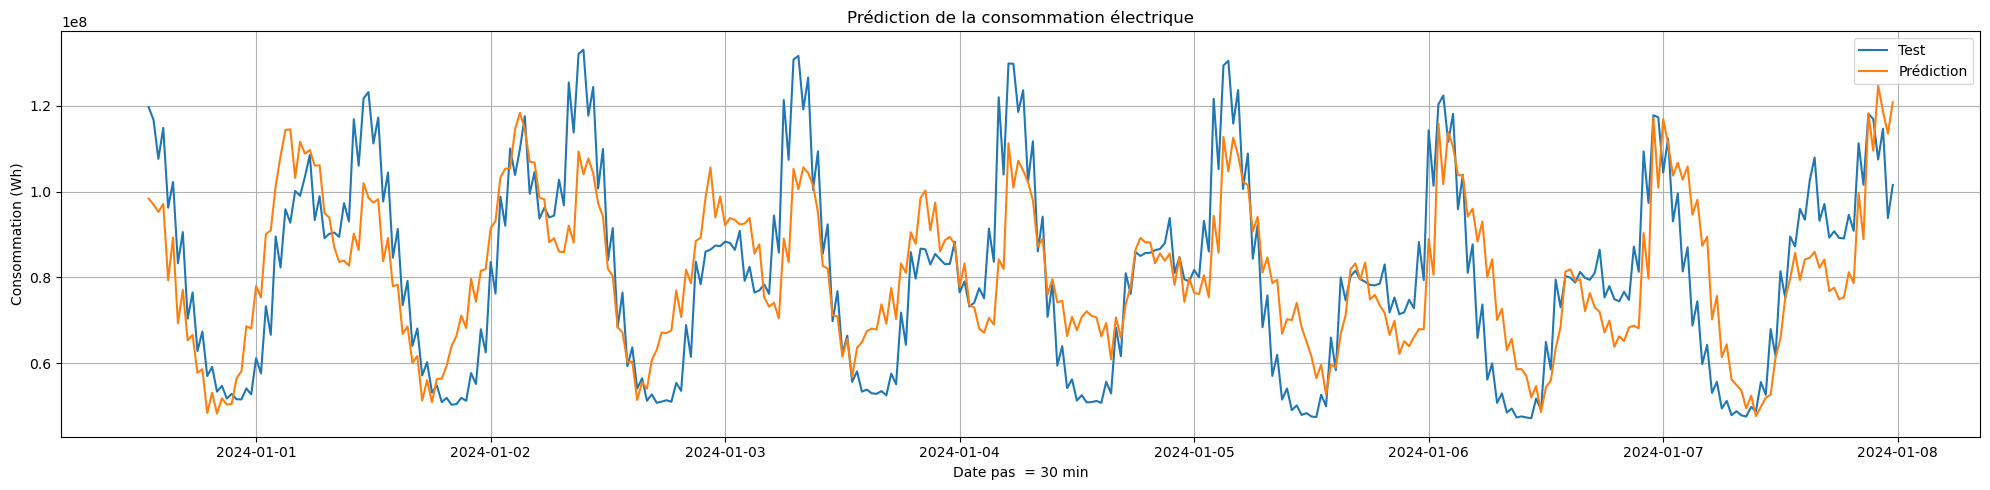

In [19]:
# Reconstitution
y_test = X_test['Total énergie soutirée (Wh)']* X_test['Nb points soutirage'] 
y_prediction = X_1_prediction*X_2_prediction*X_3_prediction* X_4_prediction * X_test['Nb points soutirage']


plt.figure(figsize=(20,5))
plt.plot(y_test, label= 'Test')

plt.plot(pd.Series(y_prediction, index=X_test.index),  label= 'Prédiction')
plt.title(f"Prédiction de la consommation électrique")
plt.xlabel("Date pas  = 30 min")
plt.ylabel("Consommation (Wh)")
plt.legend()
plt.grid(True)
plt.tight_layout() 
#Evaluation
from sklearn.metrics import mean_squared_error
mape = mean_absolute_percentage_error(y_test, y_prediction)
mae = mean_absolute_error(y_test, y_prediction)
rmse = mean_squared_error(y_test, y_prediction)
print(f"MAPE: {mape:.2%}")
print(f"MAE: {mae:.2}")

print(f"NRMSE: {np.sqrt(rmse):.2}")

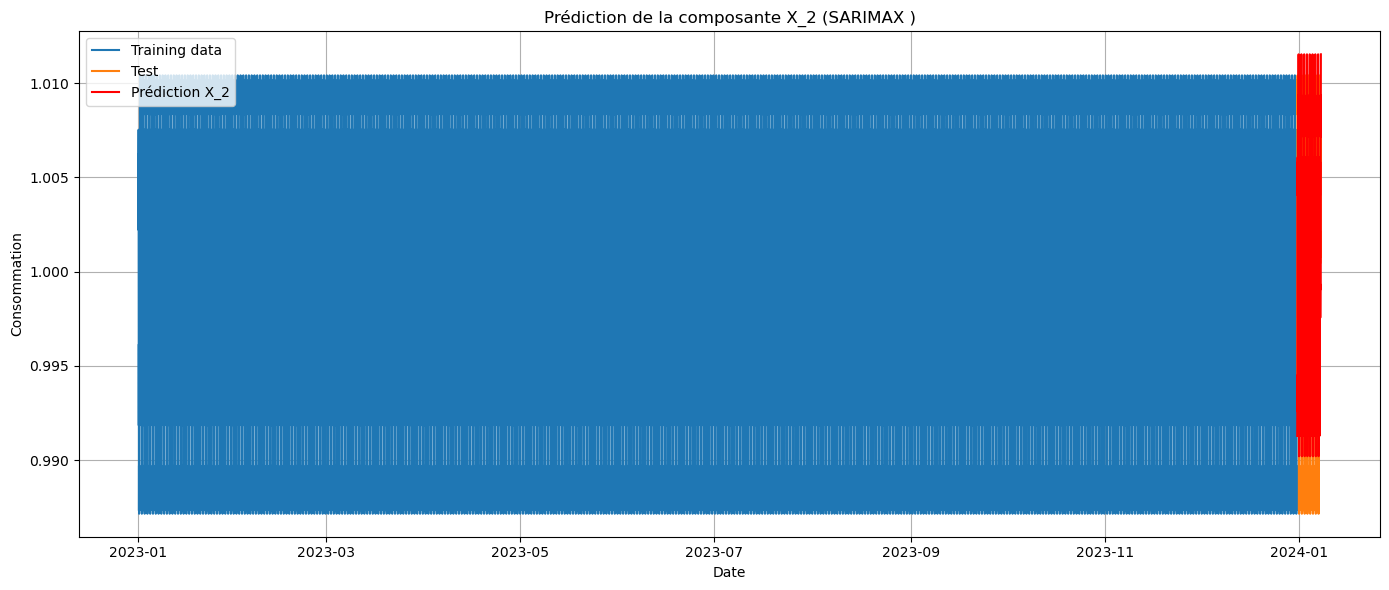

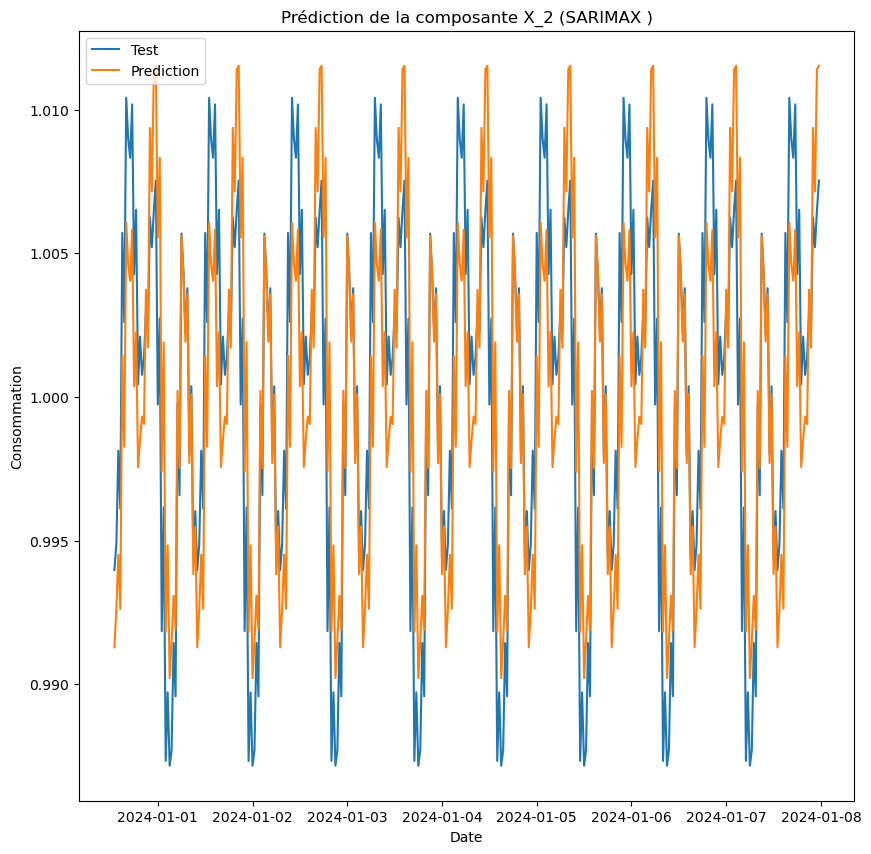

MAPE: 0.28%


In [26]:
# Affichage
num = 2
if num == 1:
    Test =  X_1_test
    Predict = X_1_prediction
    Train = X_1_train
if num == 2:
    Test =  X_2_test
    Predict = X_2_prediction
    Train = X_2_train
if num == 3:
    Test =  X_3_test
    Predict = X_3_prediction  
    #Predict =X_3_prediction_v2 # 
    Train = X_3_train
if num == 4:
    Test =  X_4_test
    Predict = X_4_prediction  
    #Predict =X_3_pred_correction # 
    Train = X_4_train
plt.figure(figsize=(14, 6))
plt.plot(Train, label = 'Training data')
plt.plot(Test, label ='Test')
plt.plot(Predict, label= f"Prédiction X_{num}", color='red')
#plt.fill_between(X_1_prediction.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.05)
plt.title(f"Prédiction de la composante X_{num} (SARIMAX )")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.grid(True)
plt.tight_layout() 




# MAP pour X_1
plt.figure(figsize=(10,10))
#plt.plot(train, label = 'Training data')
plt.plot(Test, label ='Test')
plt.plot(Predict, label ="Prediction")

#plt.fill_between(prediction.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title(f"Prédiction de la composante X_{num} (SARIMAX )")
plt.xlabel("Date")
plt.ylabel("Consommation")

plt.legend()
plt.show()
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
import matplotlib.pyplot as plt


#Erreur mape 
mape = mean_absolute_percentage_error(Test, Predict)
print(f"MAPE: {mape:.2%}")

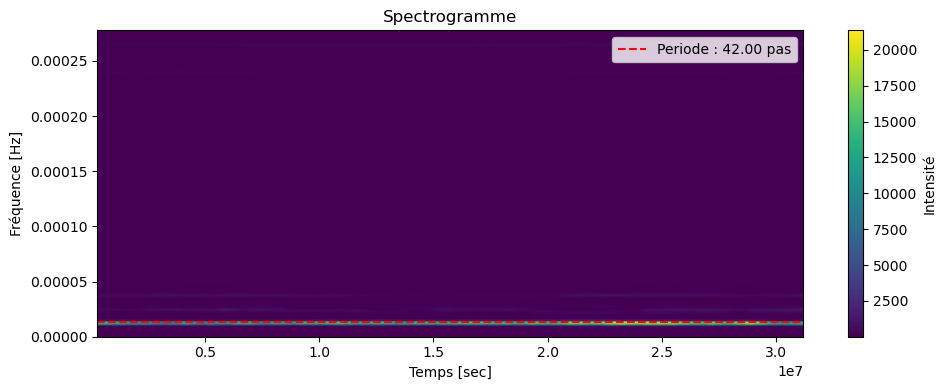

[42.0]


In [21]:
#Atitre d'explication pour l'analyse spectrale
spectro_params_default ={"fs": 1/1800, # Fréquence d'échantillonnage (1 point chaque 1800 secondes
                         "window": "hann",         # Fenêtre de Hann
                         "nperseg": 7*48,         # Longueur de la fenêtre d'analyse spectrale
                         "noverlap": 24,           # Recouvrement entre fenêtres
                         "threshold": 0.25      # Seuil de detection
                        } 
spectrogram_analyzer = SpectrogramAnalysis(**spectro_params_default) 
    
spectrogram_analyzer.fit(X_3_train)
spectrogram_analyzer.transform(X_3_train) 
liste_periode = spectrogram_analyzer.dominant_periodes.tolist()
spectrogram_analyzer.plot_spectrogramme()
print(liste_periode)